In [1]:
import sys
import tqdm
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
from scipy import stats
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression as sklr
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'install_rate', 'personal_status', 'debtors', 'residence', 'property', 'age', 'install_plans', 'housing', 'num_credits', 'job', 'num_liable', 'telephone', 'foreign_worker', 'credit']
df = pd.read_table('german.data', names=cols, sep=" ", index_col=False)

**Pre-processing** (categorical to numerical)

In [4]:
def preprocess(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3    
    
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)    
    df = pd.concat([df, pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)

    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2    
    
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)    
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)        
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['housing'], prefix='housing')],axis=1)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)    
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    
    df['credit'] = df['credit'].replace(2, 0) #1 = Good, 2= Bad credit risk

#     process age
#     df.loc[(df['age'] >= 15) & (df['age'] <= 24) , 'age'] = 0
#     df.loc[(df['age'] >= 25) & (df['age'] <= 34) , 'age'] = 1
#     df.loc[(df['age'] >= 35) & (df['age'] <= 44) , 'age'] = 2
#     df.loc[(df['age'] >= 45) & (df['age'] <= 54) , 'age'] = 3
#     df.loc[(df['age'] >= 55) & (df['age'] <= 64) , 'age'] = 4
#     df.loc[(df['age'] >= 65) , 'age'] = 5

    return df

df = preprocess(df)

y = df['credit']
df = df.drop(columns=['purpose', 'personal_status', 'housing', 'credit'])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

**Protected, privileged**

In [5]:
# protected: 'gender'=0
# privileged: 'gender'=1

# protected: 'age'=0
# privileged: 'age'=1

**Parametric Model**

In [6]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.sklearn_lr = sklr(random_state=0, max_iter=300)
        self.lr = torch.nn.Linear(X_train.shape[-1],1,bias=True)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self,x):
        x = self.lr(x)
        x = self.sm(x)
        return x.squeeze()
    
    def fit(self, x, y, learning_rate=1, c=0.03, epoch_num=1000, verbose=False):
        self.sklearn_lr.fit(x, y)
        self.lr.weight.data = torch.FloatTensor(self.sklearn_lr.coef_)
        self.lr.bias.data = torch.FloatTensor(self.sklearn_lr.intercept_)
#         criterion = logistic_loss_torch
#         optimizer = torch.optim.LBFGS(self.parameters())
#         x = torch.FloatTensor(x)
#         y = torch.FloatTensor(y)
#         self.train()
#         for _ in range(epoch_num):
#             def closure():
#                 optimizer.zero_grad()
#                 y_pred = self.forward(x)
#                 loss = criterion(y_pred, y)
#                 l2_reg = 0
#                 for param in self.parameters():
#                     l2_reg += torch.norm(param)
#                 loss += c * l2_reg
#                 loss.backward()
#                 return loss
#             optimizer.step(closure)
            
#             if verbose and (epoch_num % 50):
#                 print(f'epoch:{epoch_num}, loss:{loss.item()}')
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
    
    def predict_proba(self, x):
        self.eval()
        return self.forward(torch.FloatTensor(x)).detach().numpy()

**Compute fairness metric**

In [8]:
def computeFairness(y_pred, X_test, y_test, metric): 
    fairnessMetric = 0
    protected_idx = X_test[X_test['age']==0].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['age']==1].index
    numPrivileged = len(privileged_idx)

    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]]
    p_protected /= len(protected_idx)

    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]]
    p_privileged /= len(privileged_idx)
    
    # statistical parity difference
    statistical_parity = p_protected - p_privileged
    
    # equality of opportunity, or 
    # true positive rate parity
    # P(Y=1 | Y=1, G=0)- P(Y=1 | Y=1, G=1)
    true_positive_protected = 0
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
            true_positive_protected += y_pred[protected_idx[i]]
    tpr_protected = true_positive_protected/actual_positive_protected

    true_positive_privileged = 0
    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            true_positive_privileged += y_pred[privileged_idx[i]]
    tpr_privileged = true_positive_privileged/actual_positive_privileged

    tpr_parity = tpr_protected - tpr_privileged
    
    # equalized odds or TPR parity + FPR parity
    # false positive rate parity
    
    # predictive parity
    p_o1_y1_s1 = 0
    p_o1_s1 = 0
    for i in range(len(protected_idx)):
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        p_o1_s1 += y_pred[protected_idx[i]]
        if (y_test[protected_idx[i]] == 1):
            p_o1_y1_s1 += y_pred[protected_idx[i]]
    ppv_protected = p_o1_y1_s1/p_o1_s1
    
    p_o1_y1_s0 = 0
    p_o1_s0 = 0
    for i in range(len(privileged_idx)):
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        p_o1_s0 += y_pred[privileged_idx[i]]
        if (y_test[privileged_idx[i]] == 1):
            p_o1_y1_s0 += y_pred[privileged_idx[i]]
    ppv_privileged = p_o1_y1_s0/p_o1_s0
    
    predictive_parity = ppv_protected - ppv_privileged
    
    if (metric == 0):
        fairnessMetric = statistical_parity
    elif (metric == 1):
        fairnessMetric = tpr_parity
    elif (metric == 2):
        fairnessMetric = predictive_parity
        
    return fairnessMetric

**Influence of points computed using ground truth**

In [9]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train, verbose=True)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [10]:
c = 1e-8  # small constant
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i] != 0 and y_pred[i] != 1):
            loss += - y_true[i] * math.log(y_pred[i] + c) - (1 - y_true[i]) * math.log(1 - y_pred[i] + c)
    loss /= len(y_true)
    return loss

def binary_cross_entropy(y_pred, y_true):
    loss = -(torch.log(y_pred+c)*y_true + torch.log(1-y_pred+c)*(1-y_true))
    return loss.mean()

# logistic_loss_torch = torch.nn.functional.binary_cross_entropy
logistic_loss_torch = binary_cross_entropy

**Compute Accuracy** 

In [11]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**First-order derivative of loss function at z with respect to model parameters**

In [12]:
def del_L_del_theta_i(model, x, y_true, retain_graph=False):
    loss = logistic_loss_torch(model(torch.FloatTensor(x)), torch.FloatTensor([y_true]))
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(loss, w, create_graph=True, retain_graph=retain_graph)

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [13]:
def del_f_del_theta_i(model, x, retain_graph=False):
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(model(torch.FloatTensor(x)), w, retain_graph=retain_graph)

In [14]:
def convert_grad_to_ndarray(grad):
    grad_list = list(grad)
    for i in range(len(grad_list)):
        next_params = grad_list[i].detach().squeeze().numpy()
        if len(next_params.shape)==0:
            next_params = np.expand_dims(next_params, axis=0)
        if i == 0:
            grad_arr = next_params
        else:
            grad_arr = np.concatenate([grad_arr, next_params])
    return grad_arr

def convert_grad_to_tensor(grad):
    grad_list = list(grad)
    for i in range(len(grad_list)):
        next_params = grad_list[i].squeeze()
        if len(next_params.shape)==0:
            next_params = next_params.unsqueeze(0)
        if i == 0:
            grad_arr = next_params
        else:
            grad_arr = torch.cat([grad_arr, next_params])
    return grad_arr

**Computing $v=\nabla($Statistical parity difference$)$**

In [15]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(model, X_test_orig, X_test):
    num_params = X_test.shape[1]+1
    del_f_protected = np.zeros((num_params,))
    del_f_privileged = np.zeros((num_params,))
    numPrivileged = X_test_orig['age'].sum()
    numProtected = len(X_test_orig) - numPrivileged
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(model, X_test[i])
        del_f_i_arr = convert_grad_to_ndarray(del_f_i)
        if X_test_orig.iloc[i]['age'] == 1: #privileged
            del_f_privileged += del_f_i_arr
        elif X_test_orig.iloc[i]['age'] == 0:
            del_f_protected += del_f_i_arr
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = del_f_protected - del_f_privileged
    return v

**Computing $v=\nabla($TPR parity difference$)$**

In [16]:
# Return v = del(TPR_parity)/del(theta)
def del_tpr_parity_del_theta(model, X_test_orig, X_test, y_test):
    num_params = X_test.shape[1]+1
    del_f_protected = np.zeros((num_params,))
    del_f_privileged = np.zeros((num_params,))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
            del_f_i = del_f_del_theta_i(model, X_test[privileged_idx[i]])
            del_f_i_arr = convert_grad_to_ndarray(del_f_i)
            del_f_privileged = np.add(del_f_privileged, del_f_i_arr)
    del_f_privileged /= actual_positive_privileged
    
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
            del_f_i = del_f_del_theta_i(model, X_test[protected_idx[i]])
            del_f_i_arr = convert_grad_to_ndarray(del_f_i)
            del_f_protected = np.add(del_f_protected, del_f_i_arr)
    del_f_protected /= actual_positive_protected

    v = del_f_protected - del_f_privileged
    return v

**Computing $v=\nabla($Predictive parity difference$)$**

In [17]:
# Return v = del(Predictive_parity)/del(theta)
def del_predictive_parity_del_theta(model, X_test_orig, X_test, y_test):
    num_params = X_test.shape[1]+1
    y_pred = model.predict_proba(X_test)
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    u_dash_protected = np.zeros((num_params, 1))
    v_protected = 0
    v_dash_protected = np.zeros((num_params, 1))
    u_protected = 0
    for i in range(len(protected_idx)):
        del_f_i = del_f_del_theta_i(model, X_test[protected_idx[i]])
        del_f_i_arr = convert_grad_to_ndarray(del_f_i)
        v_protected += y_pred[protected_idx[i]][1]
        v_dash_protected = np.add(v_dash_protected, del_f_i_arr)
        if (y_test[protected_idx[i]] == 1):
            u_dash_protected = np.add(u_dash_protected, del_f_i_arr)
            u_protected += y_pred[protected_idx[i]][1]
    del_f_protected = (u_dash_protected * v_protected - u_protected * v_dash_protected)/(v_protected * v_protected)
    
    u_dash_privileged = np.zeros((num_params, 1))
    v_privileged = 0
    v_dash_privileged = np.zeros((num_params, 1))
    u_privileged = 0
    for i in range(len(privileged_idx)):
        del_f_i = del_f_del_theta_i(model, X_test[privileged_idx[i]])
        del_f_i_arr = convert_grad_to_ndarray(del_f_i)
        v_privileged += y_pred[privileged_idx[i]][1]
        v_dash_privileged = np.add(v_dash_privileged, del_f_i_arr)
        if (y_test[privileged_idx[i]] == 1):
            u_dash_privileged = np.add(u_dash_privileged, del_f_i_arr)
            u_privileged += y_pred[privileged_idx[i]][1]
    del_f_privileged = (u_dash_privileged * v_privileged - u_privileged * v_dash_privileged)/(v_privileged * v_privileged)
    
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [18]:
def hvp(y, w, v):
    ''' Multiply the Hessians of y and w by v.'''
    # First backprop
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(convert_grad_to_tensor(first_grads), v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

In [19]:
def hessian_one_point(model, x, y):
    x, y = torch.FloatTensor(x), torch.FloatTensor([y])
    loss = logistic_loss_torch(model(x), y)
    params = [ p for p in model.parameters() if p.requires_grad ]
    first_grads = convert_grad_to_tensor(grad(loss, params, retain_graph=True, create_graph=True))
    hv = np.zeros((len(x)+1, len(x)+1))
    for i in range(len(first_grads)):
        hv[i, :] = convert_grad_to_ndarray(grad(first_grads[i], params, create_graph=True)).ravel()
    return hv

In [20]:
# Compute multiplication of inverse hessian matrix and vector v
def s_test(model, xs, ys, v, damp=0.01, scale=25.0, r=5000, recursive=False, verbose=False):
    ''' Arguments:
        xs: list of data points
        ys: list of true labels corresponding to data points in xs
        damp: dampening factor
        scale: scaling factor
        r: number of iterations aka recursion depth
            should be enough so that the value stabilises.
        recursive: determine whether to recursively approximate hinv_v'''
    xs, ys = torch.FloatTensor(xs.copy()), torch.FloatTensor(ys.copy())
    n = len(xs)
    sample = np.random.choice(range(n), r, replace=True)
    hinv_v = copy.deepcopy(v)
    if recursive:
        if verbose:
            print('Computing s_test...')
            tbar = tqdm.tqdm(total=r)
        for i in range(r):
            sample_idx = sample[i]
            x, y = xs[sample_idx], ys[sample_idx]
            loss = logistic_loss_torch(model(x), y)
            params = [ p for p in model.parameters() if p.requires_grad ]
            hv = convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_v)))
            # Recursively caclulate h_estimate
            hinv_v = v + (1 - damp) * hinv_v - hv / scale
            if verbose:
                tbar.update(1)
    else:
        scale = 1.0
        hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
        hinv_v = np.matmul(hinv, v)

    return hinv_v / scale

**First-order influence computation**

In [21]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf)
    return infs

**Second-order influence computation for a group of points in subset U**

In [22]:
def second_order_influence(model, X_train, y_train, U, del_L_del_theta, r=-1, verbose=False):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params,))
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= s_test(model, X_train, y_train, del_L_del_theta_sum)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        x, y = torch.FloatTensor(X_train[idx]), torch.FloatTensor([y_train[idx]])
        loss = logistic_loss_torch(model(x), y)
        params = [ p for p in model.parameters() if p.requires_grad ]
        hessian_U_hinv_del_L_del_theta += convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_del_L_del_theta)))

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * s_test(model, X_train, y_train, hessian_U_hinv_del_L_del_theta)
    sum_term = term1 + term2
    return sum_term

**Metrics: Initial state**

In [23]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
num_params = X_train.shape[1] + 1  # weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.11221257958095521
Initial TPR parity:  -0.08652219089995561
Initial predictive parity:  -0.09399734355860345
Initial loss:  0.5060894847387476
Initial accuracy:  0.755


In [24]:
hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.append(hessian_one_point(clf, X_train[i], y_train[i])/len(X_train))

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [25]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.append(convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], y_train[i])))

*Select delta fairness function depending on selected metric*

In [26]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(clf, X_test_orig, X_test)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(clf, X_test_orig, X_test, y_test)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(clf, X_test_orig, X_test, y_test)

In [27]:
hinv_v = s_test(clf, X_train, y_train, v1, r=5000, verbose=False)

**First-order influence of each training data point**

In [28]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Checking ground truth, first-order and second-order influences for a set**

In [29]:
metric = 0
if metric == 0:
    print("Statistical parity ")
elif metric == 1:
    print("True positive rate parity ")
elif metric == 2:
    print("Predictive parity")
    
active = 1
if active:
    predicates = ['age']
    idx = X_train_orig.index 
    for pred in predicates:
        idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
        idx = idx.intersection(idx0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta, r=5000)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    print("Second-order influence: ", del_f_2)
    
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(np.array(X), np.array(y))
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0)
    print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1) - tpr_parity_0)
    print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2) - predictive_parity_0)
    
    spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
    print("Ground truth statistical parity after removing subset: ", spd_1)
    
    tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
    print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

    predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
    print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

    loss_1 = logistic_loss(y_test, y_pred_test)
    print("Loss after removing subset: ", loss_1)

    accuracy_1 = computeAccuracy(y_test, y_pred_test)
    print("Accuracy after removing subset: ", accuracy_1)

Statistical parity 
First-order influence:  0.008371113247583627
Second-order influence:  0.01315802168565447
#Rows removed:  161
#Rows left:  639
Ground truth influence of subset (on statistical parity):  0.19263299780432142
Ground truth influence of subset (on tpr parity):  0.1793093003819637
Ground truth influence of subset (on predictive parity):  -0.031184821138505958
Ground truth statistical parity after removing subset:  0.08042041822336621
Ground truth tpr parity after removing subset:  0.09278710948200808
Ground truth predictive parity after removing subset:  0.09278710948200808
Loss after removing subset:  0.5218575579728556
Accuracy after removing subset:  0.735


**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [30]:
# print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
# sampleSize = int(.2 * len(X_train))
# for i in range(100):
#     idx = random.sample(range(1, len(X_train)), sampleSize) 
    
#     # Ground truth subset influence
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y, learning_rate=.05)
#     y_pred_test = clf.predict_proba(X_test)
#     inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0

#     # First-order subset influence
#     del_f_1 = 0
#     for j in range(len(idx)):
#         del_f_1 += infs_1[idx[j]]
    
#     # Second-order subset influence
#     size_hvp = 1
#     params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta, r=5000)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)
    
#     print(inf_gt, del_f_1, del_f_2, sep=", ")

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

***NOTE:*** The retraining of the clf would cause the change in model parameters and thus lead to the change of gradients, so in this part, we first acquire all the first- and second-order influence functions together based on the original model. After all the influence functions are calculated, we retrain the model corresponding to different removed coherent subset of data and get the ground truth.

In [31]:
# Get the original model
clf = LogisticRegression()
clf.fit(X_train, y_train)

In [32]:
attributes = []
attributeValues = []
first_order_influences = []
second_order_influences = []
gt_influences = []
fractionRows = []

# print("Attribute, Value, Ground-truth subset, Add 1st-order inf individual, \
# Second-order subset influence, %rowsRemoved, Accuracy")
clf.fit(X_train, y_train)
continuous_cols = ['duration', 'credit_amt', 'install_rate', 'num_credits', 'residence']
for col in X_train_orig.columns:
    if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
        vals = [1]
    else:
        vals = X_train_orig[col].unique()
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 

        # First-order subset influence
        del_f_1 = 0            
        for i in range(len(idx)):
            del_f_1 += infs_1[idx[i]]

        # Second-order subset influence
        params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta)
        del_f_2 = np.dot(v1.transpose(), params_f_2)
        
        attributes.append(col)
        attributeValues.append(val)
        first_order_influences.append(del_f_1)
        second_order_influences.append(del_f_2)
#         gt_influences.append(inf_gt)
        fractionRows.append(len(idx)/len(X_train)*100)

#         print(col, val, inf_gt, del_f_1, del_f_2, len(idx)/len(X_train), accuracy, sep=", ")

In [33]:
for col in X_train_orig.columns:
    if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
        vals = [1]
    else:
        vals = X_train_orig[col].unique()
    for val in vals:
        idx = X_train_orig[X_train_orig[col] == val].index 
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        inf_gt = 0
        if len(y.unique()) > 1:
            # Ground truth subset influence
            clf.fit(np.array(X), np.array(y))
            y_pred = clf.predict_proba(np.array(X_test))
            if metric == 0:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
            elif metric == 1:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1) - tpr_parity_0
            elif metric == 2:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2) - predictive_parity_0
            accuracy = computeAccuracy(y_test, y_pred)
        gt_influences.append(inf_gt)

In [34]:
expl = [attributes, attributeValues, first_order_influences, second_order_influences, gt_influences, fractionRows]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["attributes", "attributeValues", "first_order_influences", "second_order_influences", "gt_influences", "fractionRows"])

In [35]:
explanations.sort_values(by=['second_order_influences'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows
19,savings,0,0.026678158068527618,0.07559122635699916,0.0739453701069579,60.25
53,num_liable,1,0.027440206584480716,0.0670064319435637,0.028642490430502265,85.5
69,gender,0,0.03441696389243348,0.0472832586045665,0.041324158152565404,32.125
36,residence,2,0.03172076846950626,0.045867903094701346,0.04739787077996882,31.125000000000004
56,telephone,1,0.022517527722862248,0.04048863105610448,0.03823116538114846,39.625
26,install_rate,4,0.016100150172919492,0.034992068659528336,0.036845452967099845,47.625
13,credit_amt,0,0.015691412180983216,0.03478706489288467,0.032398425578139656,44.0
44,install_plans,1,0.018818691924672976,0.029347888698934177,0.05692533720284698,19.5
45,num_credits,1,0.007625214326498943,0.028977230079090033,0.03082095127465434,63.125
63,purpose_A43,1,0.02125102673870723,0.026903268416805903,0.04513004585169256,28.125


In [36]:
explanations.sort_values(by=['gt_influences'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows
42,age,1,0.008371113247583627,0.01315802168565447,0.19263299780432142,20.125
57,foreign_worker,1,0.005896798552599403,0.011304330346888491,0.0774572879337938,96.25
19,savings,0,0.026678158068527618,0.07559122635699916,0.0739453701069579,60.25
44,install_plans,1,0.018818691924672976,0.029347888698934177,0.05692533720284698,19.5
36,residence,2,0.03172076846950626,0.045867903094701346,0.04739787077996882,31.125000000000004
63,purpose_A43,1,0.02125102673870723,0.026903268416805903,0.04513004585169256,28.125
69,gender,0,0.03441696389243348,0.0472832586045665,0.041324158152565404,32.125
56,telephone,1,0.022517527722862248,0.04048863105610448,0.03823116538114846,39.625
26,install_rate,4,0.016100150172919492,0.034992068659528336,0.036845452967099845,47.625
13,credit_amt,0,0.015691412180983216,0.03478706489288467,0.032398425578139656,44.0


In [37]:
explanations.sort_values(by=['fractionRows'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows
57,foreign_worker,1,0.005896798552599403,0.011304330346888491,0.0774572879337938,96.25
30,debtors,0,-0.0165642271436908,-0.08540457310834171,-0.21674832820499434,90.625
17,savings,1,-0.021657135094479803,-0.026509145834043166,-0.026234488189220362,9.625
68,purpose_A49,1,-0.014255080506697358,-0.01540782057240802,-0.03266845985781397,9.375
12,credit_hist,1,-0.016920180232477124,-0.020088396664309782,-0.019690376892685935,9.25
53,num_liable,1,0.027440206584480716,0.0670064319435637,0.028642490430502265,85.5
43,install_plans,0,-0.01828655953548822,0.002483971389173334,-0.12793695204891264,80.5
7,duration,3,0.006051679052773555,0.005432316719380728,0.00428324942477043,8.25
41,age,0,-0.007838980858398889,-0.03474028035501764,-0.19921144149166142,79.875
72,housing_A152,1,0.01685208282993916,0.014949807761211353,-0.0395715486665722,70.0


In [38]:
import scipy.stats as ss
explanations["gt_rank"] = len(explanations) - ss.rankdata(explanations["gt_influences"])
explanations["so_rank"] = len(explanations) - ss.rankdata(explanations["second_order_influences"])

In [39]:
stats.kendalltau(explanations["gt_rank"], explanations["so_rank"])

KendalltauResult(correlation=0.6971492039985192, pvalue=1.5297364709033573e-18)

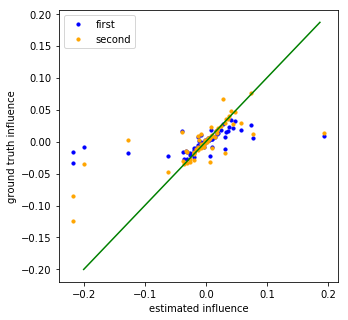

In [44]:
plt.figure(figsize=(5,5))
xs = (np.arange(30)-15)/15*0.2
ys = xs
plt.plot(xs, ys, 'g')
plt.scatter(gt_influences, first_order_influences, s=10, c='blue', label='first')
plt.scatter(gt_influences, second_order_influences, s=10, c='orange', label='second')
plt.xlabel('estimated influence')
plt.ylabel('ground truth influence')
plt.legend()

In [41]:
# bucket_num = 10
fractionRows = np.array(fractionRows)
gt_influences = np.array(gt_influences)
first_order_influences = np.array(first_order_influences)
second_order_influences = np.array(second_order_influences)
corr_first_gt_ls = []
corr_second_gt_ls = []
for bucket_id in range(10):
    is_in_bucket = np.logical_and(fractionRows>=bucket_id*10, fractionRows<(bucket_id+1)*10)
    corr_first_gt = np.corrcoef([gt_influences[is_in_bucket], first_order_influences[is_in_bucket]])[0][1]
    if np.isnan(corr_first_gt):
        corr_first_gt = 0
    corr_second_gt = np.corrcoef([gt_influences[is_in_bucket], second_order_influences[is_in_bucket]])[0][1]
    if np.isnan(corr_second_gt):
        corr_second_gt = 0
    corr_first_gt_ls.append(corr_first_gt)
    corr_second_gt_ls.append(corr_second_gt)

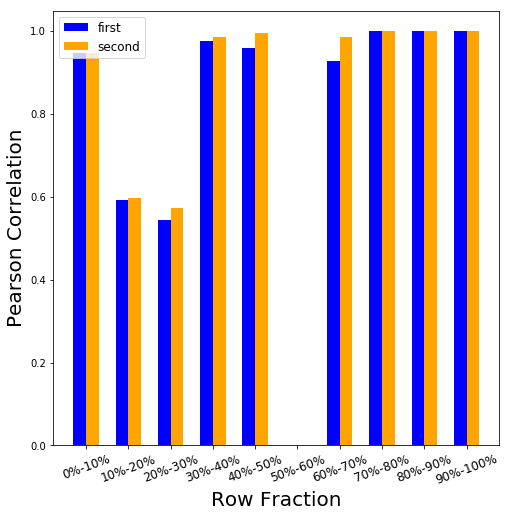

In [42]:
plt.figure(figsize=(8,8))
bar_width=0.3
tick_label=[f'{i*10}%-{(i+1)*10}%' for i in range(10)]
plt.bar(np.arange(10), corr_first_gt_ls, bar_width, color='blue', label='first')
plt.bar(np.arange(10)+bar_width, corr_second_gt_ls, bar_width, color='orange', label='second')
plt.legend(fontsize=12)
plt.xticks(np.arange(10)+bar_width/2, tick_label, rotation=20, fontsize=12)
plt.xlabel('Row Fraction', fontsize=20)
plt.ylabel('Pearson Correlation', fontsize=20)
plt.show()

less than 2 coherent subsets correspond to the bracket 50%-60%, therefore cannot compute corrsponding pearson correlation

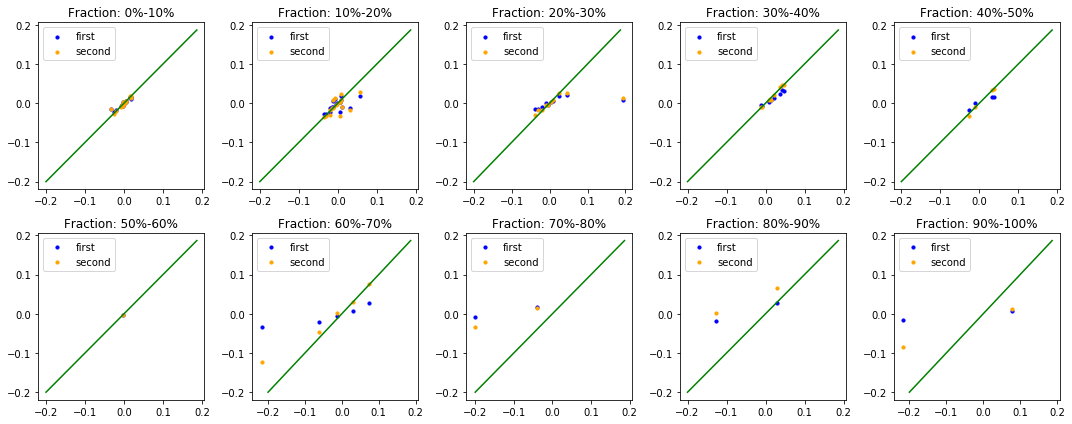

In [43]:
plt.figure(figsize=(15, 6))
for bucket_id in range(10):
    plt.subplot(2, 5, bucket_id+1)
    is_in_bucket = np.logical_and(fractionRows>=bucket_id*10, fractionRows<(bucket_id+1)*10)
    xs = (np.arange(30)-15)/15*0.2
    ys = xs
    plt.plot(xs, ys, 'g')
    plt.scatter(gt_influences[is_in_bucket], first_order_influences[is_in_bucket], s=10, c='blue', label='first')
    plt.scatter(gt_influences[is_in_bucket], second_order_influences[is_in_bucket], s=10, c='orange', label='second')
    plt.legend()
    plt.title(f'Fraction: {bucket_id*10}%-{(bucket_id+1)*10}%')
plt.tight_layout()
plt.show()

For buckets which include only small num of coherent subsets (many of them corresponds to high row fraction), the pearson correlation can be less meaningful. However, from the scatter plots above, we can see that the estimation of influence function tends to be more accurate when the row fractions are relatively low, meanwhile, low row fraction leads to low overall influence (change of metrics caused by removing the subset) of coherent subsets.